In [121]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import logging
from lime.lime_tabular import LimeTabularExplainer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from lime.lime_tabular import LimeTabularExplainer



In [122]:
file_path = '../data/processed/final.csv'
df = pd.read_csv(file_path)
# Display the first few rows of the dataset
print(df.head())

# Display column names
print(df.columns)

       Player  Fantasy Points Player Code  Match Date     Team Opponent  \
0  A Adekunle              89    1b0ce76e  2024-05-31  Nigeria   Uganda   
1  A Adekunle              16    1b0ce76e  2024-06-07  Nigeria   Malawi   
2  A Adekunle              25    1b0ce76e  2023-12-10  Nigeria  Namibia   
3  A Adekunle              16    1b0ce76e  2023-12-12  Nigeria   Rwanda   
4  A Adekunle             -14    1b0ce76e  2024-06-02  Nigeria    Kenya   

  Match Type  
0        t20  
1        t20  
2        t20  
3        t20  
4        t20  
Index(['Player', 'Fantasy Points', 'Player Code', 'Match Date', 'Team',
       'Opponent', 'Match Type'],
      dtype='object')


In [123]:
# Select inputs (columns 0, 3, 4, 5) and output (column 1)
X = df.iloc[:, [0, 3, 4, 5, 6]]  # Inputs
y = df.iloc[:, 1]             # Output
X_original = df.iloc[:, [0, 3, 4, 5, 6]]  # Inputs
# Display the selected data
print("Input (X):")
print(X.head())
# print(X)
# print(y)
print("\nOutput (y):")
print(y.head())
# X = X.values
# y = y.values
print(X)
print(y)

Input (X):
       Player  Match Date     Team Opponent Match Type
0  A Adekunle  2024-05-31  Nigeria   Uganda        t20
1  A Adekunle  2024-06-07  Nigeria   Malawi        t20
2  A Adekunle  2023-12-10  Nigeria  Namibia        t20
3  A Adekunle  2023-12-12  Nigeria   Rwanda        t20
4  A Adekunle  2024-06-02  Nigeria    Kenya        t20

Output (y):
0    89
1    16
2    25
3    16
4   -14
Name: Fantasy Points, dtype: int64
             Player  Match Date      Team    Opponent Match Type
0        A Adekunle  2024-05-31   Nigeria      Uganda        t20
1        A Adekunle  2024-06-07   Nigeria      Malawi        t20
2        A Adekunle  2023-12-10   Nigeria     Namibia        t20
3        A Adekunle  2023-12-12   Nigeria      Rwanda        t20
4        A Adekunle  2024-06-02   Nigeria       Kenya        t20
...             ...         ...       ...         ...        ...
243838  Zumika Azmi  2018-06-09  Malaysia  Bangladesh        t20
243839  Zumika Azmi  2019-02-22  Malaysia       Chi

In [124]:
def target_encode_with_smoothing(data, column, target, n_splits=5, smoothing=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded_values = np.zeros(len(data))
    global_mean = data[target].mean()  # Overall target mean
    
    for train_idx, val_idx in kf.split(data):
        train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
        # Calculate category means and counts
        category_stats = train_data.groupby(column)[target].agg(['mean', 'count'])
        category_stats['smoothed_mean'] = (
            (category_stats['count'] * category_stats['mean'] + smoothing * global_mean) /
            (category_stats['count'] + smoothing)
        )
        
        # Map the smoothed mean to validation data
        val_encoded = val_data[column].map(category_stats['smoothed_mean'])
        encoded_values[val_idx] = val_encoded.fillna(global_mean)  # Handle missing categories
    
    return encoded_values


In [125]:
X['Player'] = target_encode_with_smoothing(df, column='Player', target='Fantasy Points')
X['Team'] = target_encode_with_smoothing(df, column='Team', target='Fantasy Points')
# X['City'] = target_encode_with_smoothing(df, column='City', target='Fantasy Points')
X['Match Date'] = target_encode_with_smoothing(df, column='Match Date', target='Fantasy Points')
X['Opponent'] = target_encode_with_smoothing(df, column='Opponent', target='Fantasy Points')
label_encoder = LabelEncoder()
X['Match Type'] = label_encoder.fit_transform(X['Match Type'])
print(X)
print(y)
X = X.values
y = y.values
print(X)
print(y)

C:\Users\jaimin\AppData\Local\Temp\ipykernel_29504\3692088065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Player'] = target_encode_with_smoothing(df, column='Player', target='Fantasy Points')
C:\Users\jaimin\AppData\Local\Temp\ipykernel_29504\3692088065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Team'] = target_encode_with_smoothing(df, column='Team', target='Fantasy Points')
C:\Users\jaimin\AppData\Local\Temp\ipykernel_29504\3692088065.py:4: SettingWithCopyWarning: 
A value is trying

           Player  Match Date       Team   Opponent  Match Type
0       20.077166   35.384311  27.145748  27.764318           1
1       26.500263   37.119862  28.263993  24.440431           1
2       27.300316   23.154800  27.840687  30.574778           1
3       26.500263   41.763665  28.263993  28.829125           1
4       30.900316   37.476206  27.621938  25.883664           1
...           ...         ...        ...        ...         ...
243838   9.300316   27.828989  26.663481  46.113860           1
243839   8.857595   32.162508  27.938505  28.480967           1
243840   9.333685   20.979656  28.034949  31.706159           1
243841   8.857595   20.500066  27.938505  33.157611           1
243842   9.333685   34.102062  28.034949  33.722852           1

[243843 rows x 5 columns]
0         89
1         16
2         25
3         16
4        -14
          ..
243838   -10
243839    17
243840     0
243841    22
243842     0
Name: Fantasy Points, Length: 243843, dtype: int64
[[20.077166

C:\Users\jaimin\AppData\Local\Temp\ipykernel_29504\3692088065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Opponent'] = target_encode_with_smoothing(df, column='Opponent', target='Fantasy Points')
C:\Users\jaimin\AppData\Local\Temp\ipykernel_29504\3692088065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Match Type'] = label_encoder.fit_transform(X['Match Type'])


In [126]:
print(X)
print(X_original)

[[20.0771663  35.38431059 27.14574771 27.76431798  1.        ]
 [26.50026349 37.11986203 28.26399306 24.44043089  1.        ]
 [27.30031619 23.15479955 27.84068729 30.5747782   1.        ]
 ...
 [ 9.33368465 20.97965636 28.03494907 31.70615871  1.        ]
 [ 8.85759455 20.50006587 27.93850549 33.1576106   1.        ]
 [ 9.33368465 34.10206233 28.03494907 33.72285236  1.        ]]
             Player  Match Date      Team    Opponent Match Type
0        A Adekunle  2024-05-31   Nigeria      Uganda        t20
1        A Adekunle  2024-06-07   Nigeria      Malawi        t20
2        A Adekunle  2023-12-10   Nigeria     Namibia        t20
3        A Adekunle  2023-12-12   Nigeria      Rwanda        t20
4        A Adekunle  2024-06-02   Nigeria       Kenya        t20
...             ...         ...       ...         ...        ...
243838  Zumika Azmi  2018-06-09  Malaysia  Bangladesh        t20
243839  Zumika Azmi  2019-02-22  Malaysia       China        t20
243840  Zumika Azmi  2019-02-18

In [127]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder

# # Function for target encoding with smoothing
# def target_encode_with_smoothing(data, column, target, n_splits=5, smoothing=1):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     encoded_values = np.zeros(len(data))
#     global_mean = data[target].mean()  # Overall target mean
    
#     # Dictionary to store the encoding for later use
#     encoding_map = {}

#     for train_idx, val_idx in kf.split(data):
#         train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
#         # Calculate category means and counts
#         category_stats = train_data.groupby(column)[target].agg(['mean', 'count'])
#         category_stats['smoothed_mean'] = (
#             (category_stats['count'] * category_stats['mean'] + smoothing * global_mean) / 
#             (category_stats['count'] + smoothing)
#         )
        
#         # Save smoothed mean to encoding map for each category
#         encoding_map[column] = category_stats['smoothed_mean'].to_dict()

#         # Map the smoothed mean to validation data
#         val_encoded = val_data[column].map(category_stats['smoothed_mean'])
#         encoded_values[val_idx] = val_encoded.fillna(global_mean)  # Handle missing categories
    
#     return encoded_values, encoding_map

# # Assuming df is already loaded
# X_original = df.copy()  # Store the original data

# y = df['Fantasy Points']

# # Encoding target features with smoothing
# X = X_original.copy()  # Create a separate dataframe for encoded features

# # Encoding columns with target encoding
# X['Player'], player_encoding_map = target_encode_with_smoothing(df, column='Player', target='Fantasy Points')
# X['Team'], team_encoding_map = target_encode_with_smoothing(df, column='Team', target='Fantasy Points')
# X['Match Date'], match_date_encoding_map = target_encode_with_smoothing(df, column='Match Date', target='Fantasy Points')
# X['Opponent'], opponent_encoding_map = target_encode_with_smoothing(df, column='Opponent', target='Fantasy Points')

# # Encoding 'Match Type' using LabelEncoder
# label_encoder = LabelEncoder()
# X['Match Type'] = label_encoder.fit_transform(X_original['Match Type'])

# # Store label encoder mapping for 'Match Type'
# match_type_encoding_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# # Printing the encoded data
# print("Encoded Features (X):")
# print(X)


# # Print the original data (X_original) alongside the encoded columns
# print("\nOriginal Features (X_original):")
# print(X_original)


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92)
X_train_orginal, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y, test_size=0.2, random_state=92)
# Initialize the model
print(X_train)
print(X_train_orginal)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 400],
    'colsample_bytree': [0.3, 0.7],
    'alpha': [0, 10, 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring for regression
    cv=5,  # Number of cross-validation folds
    verbose=1,  # Display progress
    n_jobs=-1   # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


[[45.60007905 29.50668775 27.99157341 31.30659505  1.        ]
 [36.38485861 33.00638957 33.92972256 29.70677484  1.        ]
 [33.20344342 40.1538948  36.38491163 35.35490679  1.        ]
 ...
 [40.6666986  36.16671058 34.48051498 35.14422269  1.        ]
 [26.12012647 36.58445665 36.72080253 35.14096448  1.        ]
 [51.75015809 39.66358095 44.47985479 45.62477938  2.        ]]
                     Player  Match Date               Team  \
222413         T Putthawong  2023-09-06           Thailand   
21411        Akash Bhandari  2016-01-09  Hyderabad (India)   
84280             Brar Brar  2022-05-13       Punjab Kings   
176736        R Hathadurage  2022-06-19            Bahrain   
26156             Azam Khan  2022-02-03   Islamabad United   
...                     ...         ...                ...   
195467         S Periyalwar  2023-07-14            Romania   
6162                A Patil  2018-05-22         Supernovas   
31555   Dwarshuis Dwarshuis  2018-12-29      Sydney Sixers

d:\Dream11\venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'alpha': 100, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Best Score: -1213.7960854411647


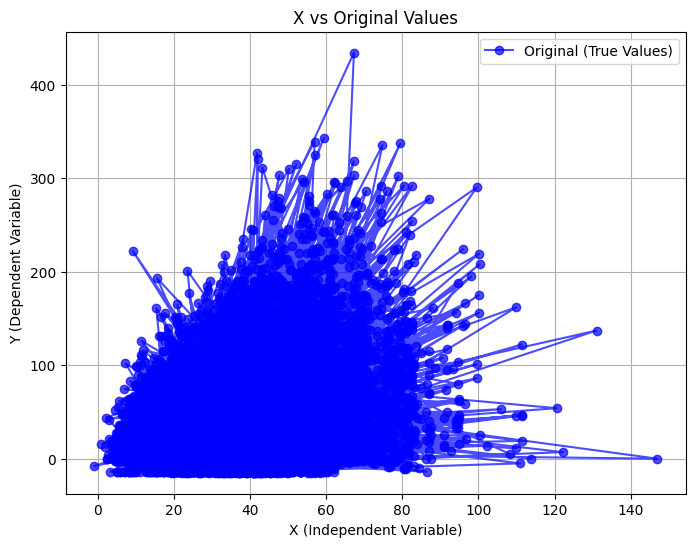

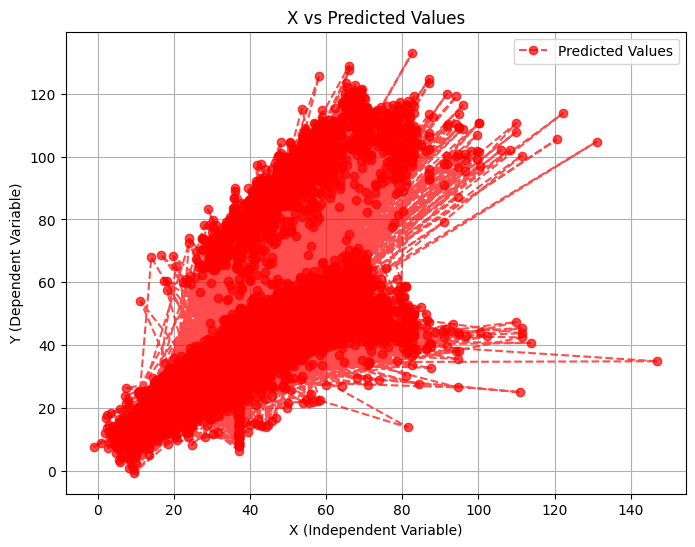

In [133]:


# Predict values using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Assuming x is a specific feature of interest
x = X_test[:, 0]  # Replace 0 with the index or column name of the independent variable

# Plot 1: X vs. Original (True) Values
plt.figure(figsize=(8, 6))
plt.plot(x, y_test, 'b-o', label="Original (True Values)", alpha=0.7)
plt.xlabel("X (Independent Variable)")
plt.ylabel("Y (Dependent Variable)")
plt.title("X vs Original Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: X vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.plot(x, y_pred, 'r--o', label="Predicted Values", alpha=0.7)
plt.xlabel("X (Independent Variable)")
plt.ylabel("Y (Dependent Variable)")
plt.title("X vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


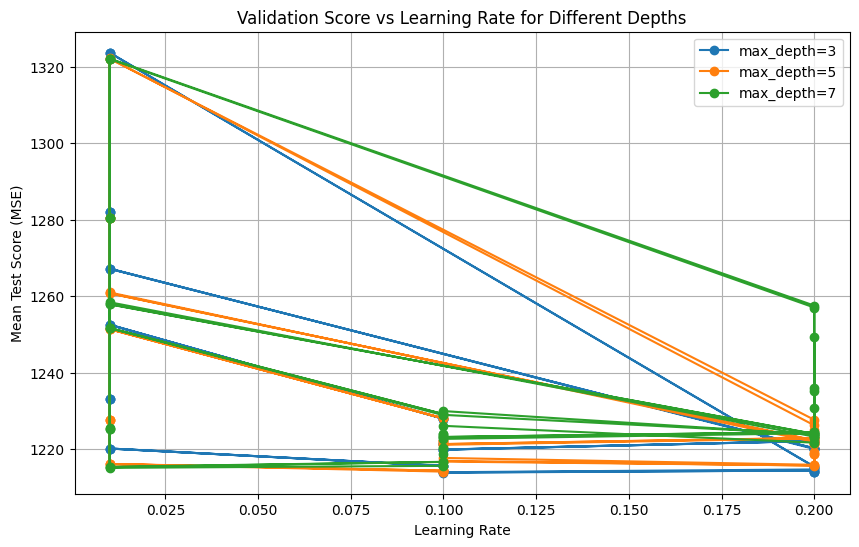

In [134]:


# Extract results from GridSearchCV
results = grid_search.cv_results_

# Parameters to compare (for simplicity, we take max_depth and learning_rate)
param_max_depth = results['param_max_depth'].data
param_learning_rate = results['param_learning_rate'].data
mean_test_score = results['mean_test_score']

# Convert scores to positive for visualization (since we used negative MSE)
mean_test_score = -mean_test_score

plt.figure(figsize=(10, 6))
for depth in np.unique(param_max_depth):
    plt.plot(
        param_learning_rate[param_max_depth == depth],
        mean_test_score[param_max_depth == depth],
        label=f"max_depth={depth}",
        marker='o'
    )

plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score (MSE)')
plt.title('Validation Score vs Learning Rate for Different Depths')
plt.legend()
plt.grid(True)
plt.show()


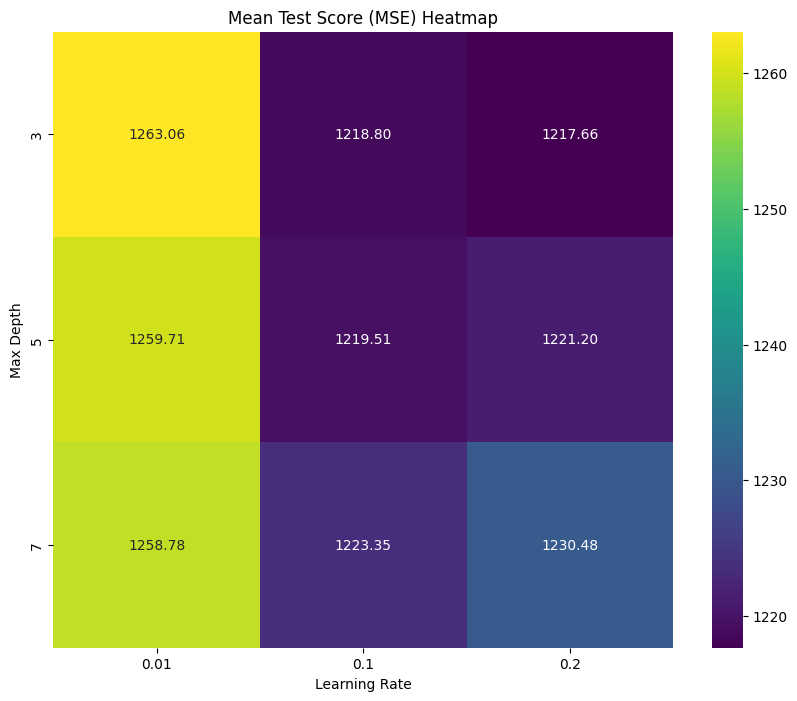

In [135]:


# Create a DataFrame for visualization
grid_results = pd.DataFrame(results)

# Pivot table for heatmap
heatmap_data = grid_results.pivot_table(
    index='param_max_depth', 
    columns='param_learning_rate', 
    values='mean_test_score'
)

# Convert negative scores back to positive for visualization
heatmap_data = -heatmap_data

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title('Mean Test Score (MSE) Heatmap')
plt.ylabel('Max Depth')
plt.xlabel('Learning Rate')
plt.show()



[[45.60007905 29.50668775 27.99157341 31.30659505  1.        ]
 [36.38485861 33.00638957 33.92972256 29.70677484  1.        ]
 [33.20344342 40.1538948  36.38491163 35.35490679  1.        ]
 ...
 [40.6666986  36.16671058 34.48051498 35.14422269  1.        ]
 [26.12012647 36.58445665 36.72080253 35.14096448  1.        ]
 [51.75015809 39.66358095 44.47985479 45.62477938  2.        ]]
range(0, 5)


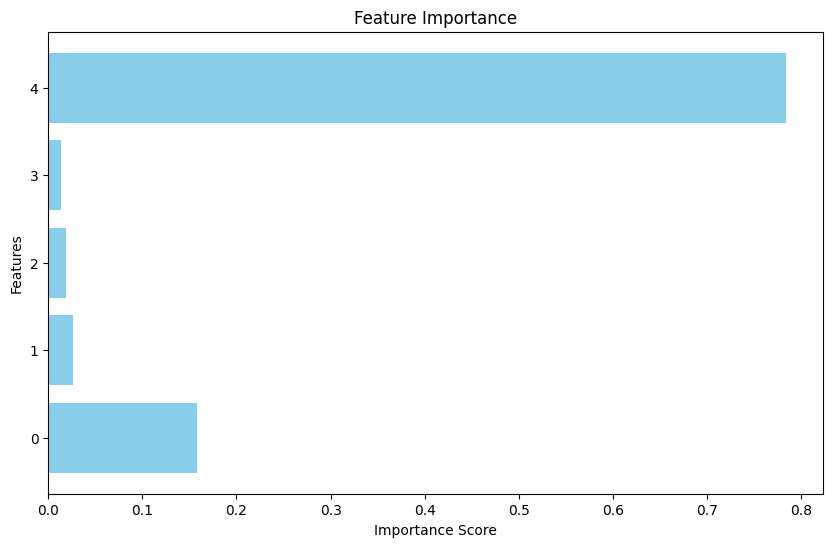

In [136]:
# Get feature importances from the best estimator
importances = grid_search.best_estimator_.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
print(X_train)
print(features)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


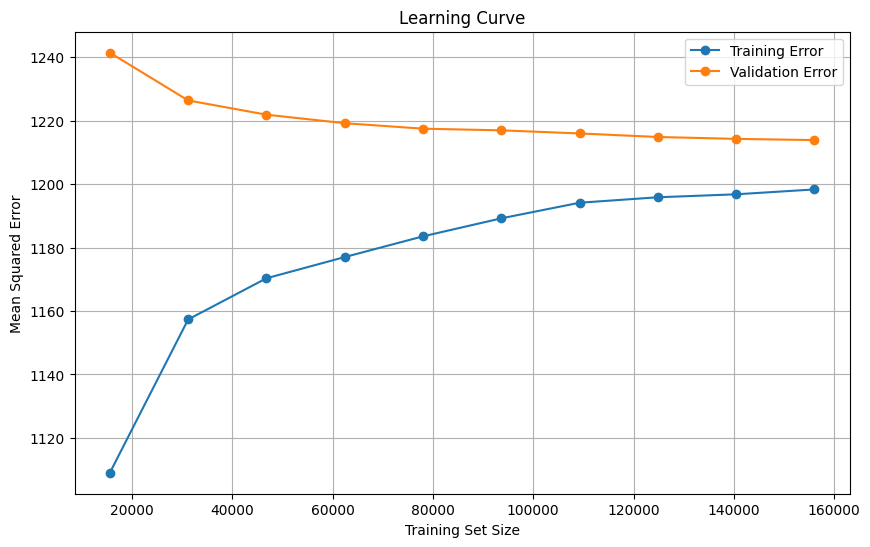

In [137]:

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Convert scores to positive for visualization
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Validation Error', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [138]:
# Evaluate the model    
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE) on test data: {mae:.4f}")

Mean Absolute Error (MAE) on test data: 26.5568


In [146]:
print(X_test.shape)
print(X_test_original.shape)
X_test_original = X_test_original.values

(48769, 5)
(48769, 5)


In [156]:

# Generate 11 random indices
random_indices = np.random.choice(X_test.shape[0], size=11, replace=False)

indices=[]
# Select the random sample and true values
random_sample = X_test[random_indices]
r = X_test_original[random_indices]
true_values = y_test[random_indices]

# Make predictions and calculate MAE
yp = 0
y_pred = model.predict(random_sample)
for i in range(11):
    #print the player names
    print(random_sample[i])
    print(r[i])
    print(true_values[i])
    print(y_pred[i])
    yp += abs(true_values[i] - y_pred[i])



mae = mean_absolute_error(true_values, y_pred)
print(yp/11)
print(f"Mean Absolute Error (MAE) on test data: {mae:.4f}")


[36.6923298  32.40822779 32.20776187 31.7589926   1.        ]
['George Bailey' '2020-01-26' 'Hobart Hurricanes' 'Adelaide Strikers'
 't20']
0
31.686075
[17.16719365 32.41306639 19.91631349 32.28984622  1.        ]
['Ma Qiancheng' '2024-02-16' 'China' 'Hong Kong' 't20']
-11
15.957592
[40.31595589 36.06378358 27.42509812 32.81980498  1.        ]
['Abdullah Akbarjan' '2024-06-16' 'Austria' 'France' 't20']
0
36.88903
[47.25649133 35.29738275 35.21285662 35.84717594  1.        ]
['M Naveed' '2016-02-22' 'United Arab Emirates' 'Oman' 't20']
76
42.81824
[35.55666582 42.92068511 34.83562366 31.85290731  1.        ]
['S Rahman' '2022-01-31' 'Chattogram Challengers' 'Comilla Victorians'
 't20']
46
35.765495
[27.53343873 29.36990633 34.68598279 35.17568427  1.        ]
['L Mills' '2023-11-03' 'Perth Scorchers' 'Melbourne Renegades' 't20']
0
28.613882
[38.77782797 29.15282169 34.68254303 50.13563747  1.        ]
['A Jones' '2024-06-23' 'United States of America' 'England' 't20']
16
24.11619
[17.85

In [157]:
feature_names = [ 'Player' , 'Match Date', 'Team', 'Opponent', 'Match Type']


In [158]:

# Assuming X_train, X_test, y_test, and model are already defined

# Step 1: Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train,            # Training data
    feature_names=feature_names,      # Names of features
    class_names=['Target'],           # Name of the target variable
    mode='regression'                 # For regression problems
)

# Step 2: Select a random instance for explanation

instance_idx = np.random.choice(X_test.shape[0])  # Random index
instance = X_test[instance_idx].reshape(1, -1)    # Reshape for prediction
true_value = y_test[instance_idx]                 # True value of the instance

# Step 3: Predict and explain
explanation = explainer.explain_instance(
    data_row=instance.flatten(),     # Instance data row
    predict_fn=model.predict         # Model's prediction function
)

# Step 4: Display the explanation


In [159]:
print(f"True value: {true_value}, Predicted value: {model.predict(instance)}")
explanation.show_in_notebook(show_table=True)  # If running in Jupyter Notebook


True value: 28, Predicted value: [32.612133]


In [160]:
def lime_explanation_to_human_text(explanation, predicted_value):
    """
    Converts a LIME explanation object into human-readable explanatory sentences.

    :param explanation: The LIME explanation object.
    :param predicted_value: The predicted value from the model.
    :return: A textual explanation of the prediction.
    """
    # Extract feature contributions
    feature_contributions = explanation.as_list()

    # Start with an overview sentence
    text_summary = f"The model predicted a value of {predicted_value:.2f} for this instance.\n"
    text_summary += "This prediction was influenced by the following factors:\n\n"

    # Process each feature and its contribution
    for feature, contribution in feature_contributions:
        if contribution > 0:
            text_summary += f"- {feature} increased the predicted value by approximately {abs(contribution):.2f}.\n"
        else:
            text_summary += f"- {feature} decreased the predicted value by approximately {abs(contribution):.2f}.\n"

    # Conclude the explanation
    text_summary += (
        "\nThe contributions above explain how the features influenced the final prediction."
    )

    return text_summary


# Example usage
predicted_value = 36.69  # Replace with the actual predicted value
text_summary = lime_explanation_to_human_text(explanation, predicted_value)
print(text_summary)



The model predicted a value of 36.69 for this instance.
This prediction was influenced by the following factors:

- Match Type <= 1.00 decreased the predicted value by approximately 33.75.
- Player <= 29.41 decreased the predicted value by approximately 16.20.
- 32.77 < Opponent <= 35.73 increased the predicted value by approximately 2.61.
- 32.78 < Team <= 35.61 decreased the predicted value by approximately 1.80.
- Match Date > 39.56 decreased the predicted value by approximately 0.53.

The contributions above explain how the features influenced the final prediction.


In [174]:
feature_contributions = explanation.as_list()
print(feature_contributions)

[('Match Type <= 1.00', -33.74970674910474), ('Player <= 29.41', -16.19575231186897), ('32.77 < Opponent <= 35.73', 2.6122294212118193), ('32.78 < Team <= 35.61', -1.8032401331410948), ('Match Date > 39.56', -0.5326438944997502)]


In [199]:

# Convert the feature contributions into a formatted string
formatted_feature_contributions = ', '.join([f"{cond}: {val:.2f}" for cond, val in feature_contributions])

# Now, create the prompt with the formatted feature contributions
prompt = f"""
    lime_output = [
     {formatted_feature_contributions}
    ]
    predicted_value = 36.69

    Assume that I am building a fantasy cricket app that has a tool (ML model) that gives the one of the predicted best player. 
    I am using LIME for its explanation, and it gave the above values. Write in a human-interpretable format 
    for the user to understand why the tool predicted that in layman terms. Write in 10-20 words in one or two lines in total mentioning fantasy points and which features effected negatively and positively.
"""
print(prompt)



    lime_output = [
     Match Type <= 1.00: -33.75, Player <= 29.41: -16.20, 32.77 < Opponent <= 35.73: 2.61, 32.78 < Team <= 35.61: -1.80, Match Date > 39.56: -0.53
    ]
    predicted_value = 36.69

    Assume that I am building a fantasy cricket app that has a tool (ML model) that gives the one of the predicted best player. 
    I am using LIME for its explanation, and it gave the above values. Write in a human-interpretable format 
    for the user to understand why the tool predicted that in layman terms. Write in 10-20 words in one or two lines in total mentioning fantasy points and which features effected negatively and positively.



In [200]:
chat_response = client.chat.complete(
    model = model,
    messages = [
        {
            "role": "user",
            "content": prompt,
        },
    ]
)

print(chat_response.choices[0].message.content)

The tool predicted 36.69 fantasy points because the player's performance and opponent's strength positively influenced the score, while the match type, team's performance, and match date had negative effects.
